In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
from sshtunnel import SSHTunnelForwarder
sys.path.append(os.path.abspath("..")) 
from data_scraping.db_utils import get_connection
from IPython.display import display

c:\Users\shane\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\shane\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


### **Get DATA from SQL**

In [2]:
conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)

cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
sales_df = pd.read_sql("SELECT * FROM market_sales", conn)

df_26 = sales_df.merge(cards_df, on='card_id', how='left')

# Get the latest sale
latest_sale = df_26.sort_values('sale_time', ascending=False).iloc[0]

print("Latest sale:")
print(latest_sale)

conn.close()


C:\Users\shane\AppData\Local\Temp\ipykernel_36492\803080092.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_36492\803080092.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_df = pd.read_sql("SELECT * FROM market_sales", conn)


Latest sale:
sale_id                      868948
card_id                       18934
platform                         ps
sale_type                      None
sale_time       2025-09-22 22:05:00
listed_price                  10500
sold_price                        0
was_sold                          0
name            Mohamed Kader Meite
game                             26
version            Team of the Week
nationality                  France
league           Ligue 1 McDonald's
club               Stade Rennais FC
position                         ST
rating                           80
weak_foot                         3
skill_move                        3
height                          192
accelerate                  Lengthy
Name: 867528, dtype: object


### **Dip Buy / Mean Reversion Strategy**

In [3]:
# Filter recent data (last 12h)
recent_df = df_26[(df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=24)) 
                  & (df_26['sold_price'] > 5000) 
                  & (df_26['platform'] == "pc")
                  & (df_26['version'] == "Gold Rare")]

buy_candidates = []

# Loop through each card
for name, group in recent_df.groupby('name'):
    group = group.sort_values('sale_time', ascending=False)
    
    if len(group) >= 30:  # need enough sales for comparison
        last_short_avg = group.head(10)['sold_price'].mean()  # short-term average
        last_long_avg = group.head(40)['sold_price'].mean()   # longer-term average

        sales_volume = group.shape[0]

        # Check drop & liquidity
        if last_short_avg < 0.90 * last_long_avg and sales_volume >= 20:
            buy_price = round(last_short_avg * 0.97)   # buy slightly below dip
            sell_price = round(last_long_avg * 0.98)  # sell slightly below average
            potential_profit = sell_price - buy_price
            drop_percent = (last_long_avg - last_short_avg) / last_long_avg * 100

            # --- Investment Rating ---
            if drop_percent >= 15 and (potential_profit / buy_price) * 100 >= 5 and sales_volume >= 30:
                rating = "🔥 High"
            elif drop_percent >= 10 and (potential_profit / buy_price) * 100 >= 3 and sales_volume >= 20:
                rating = "⚡ Medium"
            else:
                rating = "⚠️ Low"

            buy_candidates.append({
                "name": name,
                "last_short_avg": round(last_short_avg, 2),
                "last_long_avg": round(last_long_avg, 2),
                "drop_%": round(drop_percent, 2),
                "sales_volume": sales_volume,
                "suggested_buy": buy_price,
                "suggested_sell": sell_price,
                "potential_profit": potential_profit,
                "investment_rating": rating
            })
    else:
        continue  # skip cards with too few sales

# Convert to DataFrame
buy_df = pd.DataFrame(buy_candidates)

if not buy_df.empty:
    buy_df = buy_df.sort_values(["investment_rating", "drop_%"], ascending=[False, False])
    print("🔥 Potential Buy Candidates with Ratings 🔥")
    print(buy_df.head(20))
else:
    print("No buy candidates found with current filters.")


No buy candidates found with current filters.


### **Low Volatility Sniping Strategy**

In [4]:
# Filter last 24h of sales
recent_df = df_26[(df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=24)) 
                  & (df_26['sold_price'] > 6000) 
                  & (df_26['platform'] == "pc")]

volatility_candidates = []

# Loop through each card
for name, group in recent_df.groupby('name'):
    group = group.sort_values('sale_time', ascending=False)
    
    if len(group) >= 200:  # need enough sales to judge stability
        last_200 = group.head(200)['sold_price']
        avg_price = last_200.mean()
        std_dev = last_200.std()
        cv = std_dev / avg_price  # coefficient of variation (volatility measure)
        lowest_sale = last_200.min()

        # Look for stability (low volatility) and dips
        if cv < 0.05 and (lowest_sale < 0.9 * avg_price):
            suggested_buy = round(lowest_sale * 0.97)  # safe buy price just above dip
            suggested_sell = round(avg_price * 0.98)   # safe exit slightly below avg
            ea_tax = round(suggested_sell * 0.05)      # EA 5% tax
            net_profit = suggested_sell - suggested_buy - ea_tax

            volatility_candidates.append({
                "name": name,
                "avg_price": round(avg_price, 2),
                "std_dev": round(std_dev, 2),
                "volatility_%": round(cv * 100, 2),
                "lowest_sale": lowest_sale,
                "undercut_%": round((avg_price - lowest_sale) / avg_price * 100, 2),
                "sales_volume": len(last_200),
                "suggested_buy": suggested_buy,
                "suggested_sell": suggested_sell,
                "net_profit": net_profit
            })

# Convert to DataFrame
vol_df = pd.DataFrame(volatility_candidates).sort_values("net_profit", ascending=False)

print("📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉")
print(vol_df.head(20))


📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉
                               name  avg_price  std_dev  volatility_%  \
17                    Florian Wirtz  298390.00  9185.85          3.08   
39    Nuno Alexandre Tavares Mendes  196665.00  8884.11          4.52   
27                     Jules Kounde  160455.00  5802.27          3.62   
44                 Sakina Karchaoui   82817.50  4103.00          4.95   
48                    Willian Pacho  121905.00  5547.06          4.55   
20                       Harry Kane  157920.00  6687.84          4.23   
38        Nicholas Williams Arthuer  156635.00  7669.80          4.90   
40      Patricia Guijarro Gutierrez  107087.50  5246.54          4.90   
34               Marcos Aoas Correa   56300.00  2486.65          4.42   
47           Vitor Machado Ferreira   84960.00  3094.56          3.64   
10                      Desire Doue   54116.25  1562.93          2.89   
3                   Antonio Rudiger   84117.50  3660.52          4.3

### **Fluctuation Trading Strategy**

In [5]:


# Focus on recent period (last 12h)
latest_time = df_26['sale_time'].max()
recent_df = df_26[
    (df_26['sale_time'] > latest_time - pd.Timedelta(hours=12)) &
    (df_26['platform'] == 'pc') &
    (df_26['sold_price'] > 5000)
]

fluctuation_candidates = []

# Loop through each card
for name, group in recent_df.groupby("name"):
    group = group.sort_values('sale_time', ascending=False)
    latest_price = group.iloc[0]['sold_price']  # latest sale
    
    # Skip if not enough recent sales
    if len(group) < 20:
        continue
    
    prices = group['sold_price'].sort_values()
    
    # Outlier removal: 5-95 percentile
    low = prices.quantile(0.05)
    high = prices.quantile(0.95)
    clean_prices = prices[(prices >= low) & (prices <= high)]
    
    # Cap all prices at latest sale to avoid outdated spikes
    clean_prices = clean_prices[clean_prices <= latest_price * 1.05]
    
    if clean_prices.empty:
        continue
    
    avg_price = clean_prices.mean()
    min_price = clean_prices.min()
    max_price = clean_prices.max()
    spread = (max_price - min_price) / avg_price * 100
    sales_volume = len(clean_prices)
    
    # Only consider truly fluctuating cards
    if spread >= 15 and sales_volume >= 20:
        buy_price = round(min_price * 1.02)      # buy slightly above min
        sell_price = round(avg_price * 0.98)    # sell slightly below avg
        profit_margin = round(((sell_price - buy_price) / buy_price) * 100, 2)
        
        # Only recommend if profit margin is worthwhile and below latest sale
        if profit_margin > 5 and buy_price <= latest_price:
            fluctuation_candidates.append({
                "name": name,
                "latest_sale": latest_price,
                "avg_price": int(avg_price),
                "min_price": int(min_price),
                "max_price": int(max_price),
                "spread_%": round(spread, 2),
                "sales_volume": sales_volume,
                "best_buy": buy_price,
                "best_sell": sell_price,
                "profit_margin_%": profit_margin,
                "recommendation": "✅ Buy & Flip"
            })

# Convert to DataFrame and sort
fluctuation_df = pd.DataFrame(fluctuation_candidates).sort_values(
    "profit_margin_%", ascending=False
)

print("📊 Fluctuation Trading Recommendations 📊")
print(fluctuation_df.head(20))


📊 Fluctuation Trading Recommendations 📊
                             name  latest_sale  avg_price  min_price  \
5                   Clint Dempsey        48750      38648      30000   
25               Tabitha Chawinga        19000      16710      13750   
10                   Grace Geyoro        40000      36900      31250   
20               Melchie Dumornay        92000      74619      64000   
18                Mallory Swanson        19750      16884      14500   
4                     Chloe Kelly        16500      11566      10000   
21                   Peter Crouch        54000      52576      46000   
16                    Lucy Bronze         6900       6338       5600   
7           Debora C. de Oliveira        54000      44553      39750   
11                   Gregor Kobel         6200       6040       5400   
27         Trent Alexander-Arnold         7000       6476       5800   
1                   Alessia Russo        16750      15593      14000   
15                    Lo

In [6]:
vol_df['strategy'] = 'Low-Volatility Snipe'
buy_df['strategy'] = 'Momentum Crash'
fluctuation_df['strategy'] = "Fluctuation Trading"
# --- Merge both datasets ---
buy_list = pd.concat([vol_df, buy_df, fluctuation_df], ignore_index=True)

# --- Optional: filter by key metrics ---
# Example filters: volatility < 5% and undercut > 10%
# buy_list_filtered = buy_list[
#     (buy_list['volatility_%'] < 5) & 
#     (buy_list['undercut_%'] > 10)
# ]

# --- Sort by potential profit (undercut % descending) ---
buy_list_sorted = buy_list.sort_values(by='undercut_%', ascending=False)

# --- Save the combined BUY LIST ---
buy_list_sorted.to_csv("combined_buy_list.csv", index=False)

print("✅ Combined BUY LIST generated!")

✅ Combined BUY LIST generated!


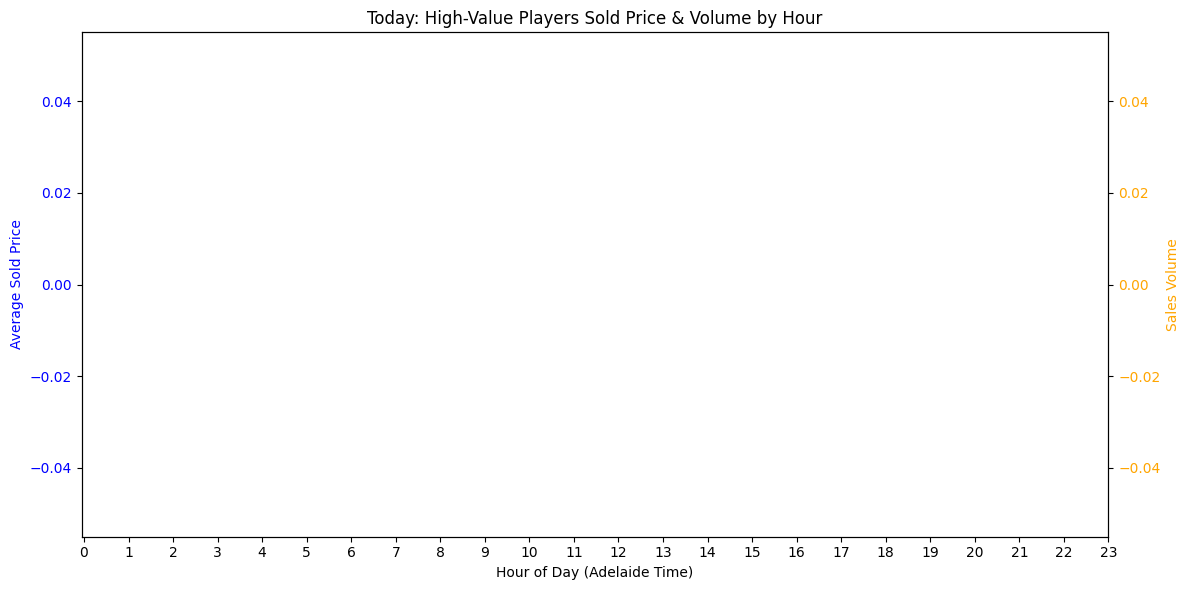

In [12]:
# Assuming df_26['sale_time'] is already in Adelaide timezone
adelaide_tz = df_26['sale_time'].dt.tz

# Yesterday's start and end
yesterday_start = pd.Timestamp.now(tz=adelaide_tz).normalize() - pd.Timedelta(days=1)
yesterday_end = yesterday_start + pd.Timedelta(days=1)

# Filter only yesterday
yesterday_df = df_26[
    (df_26['sale_time'] >= yesterday_start) &
    (df_26['sale_time'] < yesterday_end)
]



pc_yesterday_df = yesterday_df[(yesterday_df['platform'] == "pc") & (yesterday_df['name'] == "Alphonso Davies") & (yesterday_df['version'] == "Gold Rare")]


# Calculate hourly average sold price
hourly_stats = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].agg(['median','count']).reset_index()
hourly_stats = hourly_stats.sort_values('sale_time')

hourly_avg = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].mean().reset_index()
hourly_avg = hourly_avg.sort_values('sale_time')

# Group by hour
hourly = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour).agg({
    'sold_price': 'mean',
    'name': 'count'  # count of sales as volume
}).reset_index().rename(columns={'name': 'sales_volume'})

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Sold price line
ax1.plot(hourly['sale_time'], hourly['sold_price'], color='blue', marker='o', label='Average Sold Price')
ax1.set_xlabel("Hour of Day (Adelaide Time)")
ax1.set_ylabel("Average Sold Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0,24))

# Volume bars
ax2 = ax1.twinx()
ax2.bar(hourly['sale_time'], hourly['sales_volume'], color='orange', alpha=0.3, label='Sales Volume')
ax2.set_ylabel("Sales Volume", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Today: High-Value Players Sold Price & Volume by Hour")
fig.tight_layout()
plt.show()